In [1]:
#set up random seed
import numpy as np
import torch
import random

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic=True
    random.seed(seed)

In [2]:
#Handler
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
# setup_seed(2022)
#得到自定义读取的dataset  
class Messidor_Handler(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.RandomRotation(15),
                                             transforms.RandomResizedCrop(size=512, scale=(0.9, 1)),
                                             transforms.RandomHorizontalFlip(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                            ])
        

    def __getitem__(self, index):
        x, y = self.X[index], self.Y[index]
        x = Image.fromarray(np.uint8(x))
        x = self.transform(x)
        return x, y, index
    
    def __len__(self):
        return len(self.X)
    
    
class Breast_Handler(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.RandomRotation(15),
                                             transforms.RandomResizedCrop(size=512, scale=(0.9, 1)),
                                             transforms.RandomHorizontalFlip(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                            ])
        

    def __getitem__(self, index):
        x, y = self.X[index], self.Y[index]
        x = Image.fromarray(np.uint8(x))
        x = self.transform(x)
        return x, y, index
    
    def __len__(self):
        return len(self.X)
    
    
class Breast_multi_Handler(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.RandomRotation(15),
                                             transforms.RandomResizedCrop(size=512, scale=(0.9, 1)),
                                             transforms.RandomHorizontalFlip(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                            ])
        

    def __getitem__(self, index):
        x, y = self.X[index], self.Y[index]
        x = Image.fromarray(np.uint8(x))
        x = self.transform(x)
        return x, y, index
    
    def __len__(self):
        return len(self.X)
    

In [3]:
import glob
import os.path
import pandas as pd
# setup_seed(2022)
input_path = "./data/Messidor_Dataset/Annotation"
normal=[]
diseased=[]
# 使用glob读取多个文本文件 这里选取的是excel的后缀
for i in glob.glob(os.path.join(input_path,"*.xls")):
    df_data = pd.read_excel(i)
    #获得normal与非normal数据的path
    normal_path = df_data.loc[(df_data["Retinopathy grade"] == 0)]["Image name"].values
    for j in normal_path:
        normal.append("./data/Messidor_Dataset/"+i[-10:-4]+"/"+j)
    diseased_path = df_data.loc[(df_data["Retinopathy grade"] != 0)]["Image name"].values
    for k in diseased_path:
        diseased.append("./data/Messidor_Dataset/"+i[-10:-4]+"/"+k)
print(len(normal))

0


In [4]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import PIL
import cv2
# setup_seed(2022)

image_size=512
labels = []
dataset = []

def crop(image): 
    sums = image.sum(axis=0)
    sums = sums.sum(axis=1)
    filter_arr = []
    for s in sums:
        if s == 0:
            filter_arr.append(False)
        else:
            filter_arr.append(True)
    image = image[:, filter_arr]
    h = image.shape[0]
    w = image.shape[1]    
    if h < w:
        x = (w - h)//2
        image = image[:, x:x+h, :]        
    elif h > w:
        x = (h - w)//2
        image = image[x:x+w, :, :]           
    else:
        pass
    return image
    
def create_dataset(image_category,label):

    for image_path in tqdm(image_category):
        # image = PIL.Image.open(image_path)
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = crop(image)
        image = np.array(image)
        image = cv2.resize(image,(image_size,image_size))#299,299,3
        # image = transform(image)
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

def split_dataset(x,y):
    x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=2022)
    return x_train,torch.LongTensor(y_train),x_val,torch.LongTensor(y_val)


def split_train_val(x_train,y_train):
    x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=2022)
    return x_train,torch.LongTensor(y_train),x_test,torch.LongTensor(y_test)
# x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=42)
# x_val,x_test,y_val,y_test = train_test_split(x_val,y_val,test_size=0.5,random_state=42)

In [5]:
#data augumentation
from PIL import Image
from torchvision.transforms import ToTensor,ToPILImage
# import albumentations as A
import torch

def transform(x,y):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomRotation(15),
            transforms.RandomResizedCrop(size=512, scale=(0.9, 1)),
            transforms.RandomHorizontalFlip(),
            transforms.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])

        ]
    )

    X=[]
    Y=[]
    x_train=np.array(x).astype(np.float32)
    y_train=np.array(y)
    for i in range(0,len(x_train)):
        x = transform(x_train[i])
        X.append(x)
        Y.append(y_train[i])
    X=np.array(x_train)
    Y=np.array(y_train)
    return X,Y

In [6]:
#data
import numpy as np
import torch
from torchvision import datasets
from tqdm import tqdm
import cv2
#读取数据过程+结合handler
# setup_seed(2022)
class Data:
    def __init__(self, X_train, Y_train, X_test, Y_test, handler):
        self.X_train = X_train
        self.Y_train = Y_train
        # self.X_val = X_val
        # self.Y_val = Y_val
        self.X_test = X_test
        self.Y_test = Y_test
        self.handler = handler
        
        self.n_pool = len(X_train)
        self.n_test = len(X_test)
        
        self.labeled_idxs = np.zeros(self.n_pool, dtype=bool)

    def supervised_training_labels(self):
        # generate initial labeled pool 根据label index来确认 labeled_idxs就是label data反之是unlabel data（x_train+y_train)
        tmp_idxs = np.arange(self.n_pool)
        self.labeled_idxs[tmp_idxs[:]] = True
        
    def initialize_labels_random(self, num):
        # generate initial labeled pool 根据label index来确认 labeled_idxs就是label data反之是unlabel data（x_train+y_train)
        tmp_idxs = np.arange(self.n_pool)
        np.random.shuffle(tmp_idxs)
        self.labeled_idxs[tmp_idxs[:num]] = True
        
    def initialize_labels(self, dataset, num):
        tmp_idxs = np.arange(self.n_pool)
        np.random.shuffle(tmp_idxs)
        net_init = get_net(args.dataset_name, device, init=True) 
        strategy_init = get_strategy("KMeansSampling")(dataset, net_init, init=True) 
        rd = 0
        strategy_init.train(rd, init=True)
        query_idxs = strategy_init.query(args.n_init_labeled)
        strategy.update(query_idxs)
    
    def get_labeled_data(self):
        labeled_idxs = np.arange(self.n_pool)[self.labeled_idxs]
        print("labeled data",labeled_idxs.shape)
        return labeled_idxs, self.handler(self.X_train[labeled_idxs], self.Y_train[labeled_idxs])
    
    def get_unlabeled_data(self):
        unlabeled_idxs = np.arange(self.n_pool)[~self.labeled_idxs]
        return unlabeled_idxs, self.handler(self.X_train[unlabeled_idxs], self.Y_train[unlabeled_idxs])
    
    def get_train_data(self):#全体training data（label）
        return self.labeled_idxs.copy(), self.handler(self.X_train, self.Y_train)
    
    def get_val_data(self):
        return self.handler(self.X_val, self.Y_val)
        
    def get_test_data(self):
        return self.handler(self.X_test, self.Y_test)
    
    def cal_test_acc(self, preds):
        return 1.0 * (self.Y_test==preds).sum().item() / self.n_test
    
    def cal_train_acc(self, preds):
        return 1.0 * (self.Y_train==preds).sum().item() / self.n_pool
    
    def add_labeled_data(self,data,label):
        data = torch.reshape(data, (512,512,3))
        data = torch.unsqueeze(data, 0)
        self.X_train = torch.tensor(self.X_train)
        self.Y_train = torch.tensor(self.Y_train)
        self.X_train = torch.cat((self.X_train, data), 0)
        self.Y_train = torch.cat((self.Y_train, torch.tensor([label])), 0)
        
        self.labeled_idxs=np.append(self.labeled_idxs,True)
        self.n_pool+=1
        
    def update_pseudo_label(self,idx,label):
        self.X_train = torch.tensor(self.X_train)
        self.Y_train[idx] = label
    
#     def (self,data,label):
#         data = tadd_labeled_dataorch.reshape(data, (-1,512,512,3))
# #         data = torch.unsqueeze(data, 0)
#         self.X_train = torch.tensor(self.X_train)
#         self.Y_train = torch.tensor(self.Y_train)
#         self.X_train = torch.cat((self.X_train, data), 0)
#         self.Y_train = torch.cat((self.Y_train, label), 0)
#         for i in range(len(data)):
#             self.labeled_idxs=np.append(self.labeled_idxs,True)
#             self.n_pool+=1
    
    def get_label(self, idx):
        self.Y_train=np.array(self.Y_train)
        label = torch.tensor(self.Y_train[idx])
#         print(label)
        return label#所有label
    
    #efficient方法 将上一轮没有拟合好的数据+新数据返回
    def get_efficient_training_data(self,idx, new_idx):
        all_idx = np.concatenate((idx, new_idx), axis=None)
        labeled_idxs = np.arange(self.n_pool)[all_idx]
        return labeled_idxs, self.handler(self.X_train[labeled_idxs], self.Y_train[labeled_idxs])

    
#读取数据
#从库中直接获取已有数据集
def get_Messidor(handler):
    # dataset = create_dataset(normal,1)
    # dataset = create_dataset(diseased,0)
    # print(len(dataset))
    # x = np.array([i[0] for i in dataset])
    # y = np.array([i[1] for i in dataset])
    # x = torch.Tensor(x)
    # y = torch.Tensor(y)
    # torch.save(torch.Tensor(x),'./data/Messidor_Crop_x.pt')
    # torch.save(torch.Tensor(y),'./data/Messidor_Crop_y.pt')
    # x=torch.load('./data/Messidor_Dataset/x.pt')
    # y=torch.load('./data/Messidor_Dataset/y.pt')
    x=torch.load('./data/Messidor_Crop_x.pt')
    y=torch.load('./data/Messidor_Crop_y.pt')
    y=y.long()
    x,y = transform(x,y)
#     x=torch.load('./data/Messidor_transform_x.pt')
#     y=torch.load('./data/Messidor_transform_y.pt')
#     y=y.long()
    x_train,y_train,x_test,y_test = split_dataset(x,y)
    x_train,y_train,x_val,y_val = split_train_val(x_train,y_train)
    print("x_train",np.array(x_train).shape)
    print("x_val",np.array(x_val).shape)
    print("x_test",np.array(x_test).shape)
    return x_train,y_train,x_val, y_val, x_test,y_test,handler


def walk_root_dir(DIR):
    wholePathes=[]
    for dirpath, subdirs, files in os.walk(DIR):
        for x in files:
            if x.endswith(('.tif')):
                wholePathes.append(os.path.join(dirpath, x))
    return wholePathes

def Dataset_loader(input_path, RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    wholePathes=walk_root_dir(input_path)
    for PATH in tqdm(wholePathes):
        img = read(PATH)
        img = cv2.resize(img, (RESIZE,RESIZE))
        IMG.append(np.array(img))
    return IMG

def get_Breast(handler):
#     benign = np.array(Dataset_loader('./breast/histology_slides/breast/benign/SOB',512))
#     malign = np.array(Dataset_loader('./breast/histology_slides/breast/malignant/SOB',512))
#     # Create labels
#     benign_label = np.zeros(len(benign))
#     malign_label = np.ones(len(malign))

#     # Merge data 
#     x = np.concatenate((benign, malign), axis = 0)
#     y = np.concatenate((benign_label, malign_label), axis = 0)
    
#     torch.save(torch.Tensor(x),'./breast/histology_slides/breast/x.pt')
#     torch.save(torch.Tensor(y),'./breast/histology_slides/breast/y.pt')
    
    # x=torch.load('./breast/x.pt')
    # y=torch.load('./breast/y.pt')
    y=y.long()

    x_train,y_train,x_test,y_test = split_dataset(x,y)
    x_train,y_train,x_val,y_val = split_train_val(x_train,y_train)
    print("x_train",np.array(x_train).shape)
    print("x_val",np.array(x_val).shape)
    print("x_test",np.array(x_test).shape)
    return x_train,y_train,x_val, y_val, x_test,y_test,handler


def get_Breast_multi(handler):
    benign = np.array(Dataset_loader('./Breast_Cancer_Diagnosis_Dataset/ICIAR2018_BACH_Challenge/Photos/Benign',512))
    insitu = np.array(Dataset_loader('./Breast_Cancer_Diagnosis_Dataset/ICIAR2018_BACH_Challenge/Photos/InSitu',512))
    invasive = np.array(Dataset_loader('./Breast_Cancer_Diagnosis_Dataset/ICIAR2018_BACH_Challenge/Photos/Invasive',512))
    normal = np.array(Dataset_loader('./Breast_Cancer_Diagnosis_Dataset/ICIAR2018_BACH_Challenge/Photos/Normal',512))
    # Create labels
    benign_label = np.zeros(len(benign))
    insitu_label = np.ones(len(insitu))
    invasive_label = np.full(len(invasive),2)
    normal_label = np.full(len(normal),3)

    # Merge data 
    x = np.concatenate((benign, insitu, invasive, normal), axis = 0)
    y = np.concatenate((benign_label, insitu_label, invasive_label, normal_label), axis = 0)
    
    # torch.save(torch.Tensor(x),'./Breast_Cancer_Diagnosis_Dataset/x.pt')
    # torch.save(torch.Tensor(y),'./Breast_Cancer_Diagnosis_Dataset/y.pt')
    
    # x=torch.load('./Breast_Cancer_Diagnosis_Dataset/x.pt')
    # y=torch.load('./Breast_Cancer_Diagnosis_Dataset/y.pt')
    x=torch.Tensor(x)
    y=torch.Tensor(y)
    y=y.long()

    x_train,y_train,x_test,y_test = split_dataset(x,y)
    # x_train,y_train,x_val,y_val = split_train_val(x_train,y_train)
    print("x_train",np.array(x_train).shape)
    # print("x_val",np.array(x_val).shape)
    print("x_test",np.array(x_test).shape)
    return x_train,y_train,x_test,y_test,handler


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision
from collections import OrderedDict
# setup_seed(2022)
class Net:
    def __init__(self, net, params, device):
        self.net = net
        self.params = params
        self.device = device

#以轮数为停止标准   
    def train(self, data):#改为在前一个model基础上fintuning
        n_epoch = 1
        self.clf = self.net().to(self.device)
        self.clf.train()
#         if len(data)<=300:
#             n_epoch = 20
#         else:
#             n_epoch = 30
            
        # optimizer = optim.SGD(self.clf.parameters(), momentum=0.9, lr=0.0001,weight_decay=0.0005, nesterov=True)
        optimizer = optim.Adam(self.clf.parameters(), lr=0.0001,weight_decay=0.0005)
        # lr = 0.0001
        # lr = 0.000001 * len(data)#变化的lr
        # if(lr > 0.0003):
        #     lr = self.params['optimizer_args']['lr']
        # optimizer = optim.Adam(self.clf.parameters(),lr)#,weight_decay=1e-5
        
        loader = DataLoader(data, shuffle=True, **self.params['train_args'])
        for epoch in tqdm(range(1, n_epoch+1), ncols=100):
            for batch_idx, (x, y, idxs) in enumerate(loader):
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                out, e1 = self.clf(x)
                loss = F.cross_entropy(out, y)
                loss.backward()
                optimizer.step()
                
                
    def init_train(self, data):
        n_epoch = self.params['n_epoch']
        best = {'epoch':1,'loss':10}   
        self.clf = self.net().to(self.device)
        self.clf.train()
        optimizer = optim.Adam(self.clf.parameters(), lr=0.005)
        criterion = nn.MSELoss()
        loader = DataLoader(data, batch_size=16, shuffle=True)
        for epoch in tqdm(range(1, n_epoch+1), ncols=100):
            for batch_idx, (x, y, idxs) in enumerate(loader):
                self.clf.train()
                x = x.view(x.size(0), -1)
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                out, e1 = self.clf(x)
                loss = criterion(out, x)
                loss.backward()
                optimizer.step()
                train_loss+=loss#一个epoch的loss
            trigger+=1
            if train_loss/(batch_idx+1)<best['loss']:
                trigger=0
                best['epoch'] = epoch
                best['loss'] = train_loss/(batch_idx+1)
                torch.save(self.clf, './autoencoder.pth') 
            train_loss=0
            if trigger>=args.early_stop:
                break
                
#以accuracy饱和为早停标准
    def supervised_train_acc(self, data):
        best = {'epoch':1,'acc':0.5}  
        n_epoch = 300
        train_acc = 0
        trigger=0
        stop=100
        once=False
        self.clf = self.net().to(self.device)
        self.clf.train()
        # optimizer = optim.Adam(self.clf.parameters(),**self.params['optimizer_args'])#,weight_decay=1e-5
        optimizer = optim.Adam(self.clf.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=0.1, weight_decay=0.01)
#         optimizer = optim.SGD(self.clf.parameters(), momentum=0.9, lr=0.0003, weight_decay=0.01, nesterov=True)
    
        # optimizer = optim.SGD(self.clf.parameters(), **self.params['optimizer_args'])
        loader = DataLoader(data, shuffle=True, **self.params['train_args'])
        for epoch in tqdm(range(1, n_epoch+1), ncols=100):
            for batch_idx, (x, y, idxs) in enumerate(loader):
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                out, e1 = self.clf(x)
                pred = out.max(1)[1]
                loss = F.cross_entropy(out, y)
                loss.backward()
                optimizer.step()
                train_acc += 1.0 * (y==pred).sum().item() / len(x)
            train_acc = train_acc/(batch_idx+1)
#             trigger+=1
            if train_acc==1:
                break
            train_acc = 0
                
                
#以validation loss为停止标准     
    def supervised_val_loss(self, rd, data, val_data):
        n_epoch = 150
        trigger=0
        best = {'epoch':1,'loss':10}        
        validation_loss = 0
        self.clf = self.net().to(self.device)
        self.clf.train()
        # if rd==0:
        #     self.clf = self.clf
        # else:
        #     self.clf = torch.load('./model.pth') 
        # optimizer = optim.SGD(self.clf.parameters(), **self.params['optimizer_args'])
#         optimizer = optim.Adam(self.clf.parameters(), **self.params['optimizer_args'])
#         optimizer = optim.SGD(self.clf.parameters(), momentum=0.9, lr=0.0003, weight_decay=0.01, nesterov=True)
        optimizer = optim.Adam(self.clf.parameters(), lr=0.0002, eps=0.1,weight_decay=0.01)
        loader = DataLoader(data, shuffle=True, **self.params['train_args'])
        val_loader = DataLoader(val_data, shuffle=False, **self.params['val_args'])
        for epoch in tqdm(range(1, n_epoch+1), ncols=100):
            for batch_idx, (x, y, idxs) in enumerate(loader):
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                out, e1 = self.clf(x)
                loss = F.cross_entropy(out, y)
                loss.backward()
                optimizer.step()
                
            with torch.no_grad():
                self.clf.eval()
                for valbatch_idx,(valinputs,valtargets, idxs) in enumerate(val_loader):
                    valinputs,valtargets=valinputs.to(device),valtargets.to(device)
                    valoutputs, e1=self.clf(valinputs)
                    validation_loss+= F.cross_entropy(valoutputs,valtargets.long())
            trigger+=1
            #early stopping condition: if the acc not getting larger for over 10 epochs, stop
            if validation_loss/(valbatch_idx+1)<best['loss']:
                trigger=0
                best['epoch'] = epoch
                best['loss'] = validation_loss/(valbatch_idx+1)
                torch.save(self.clf, './model.pth')  
            validation_loss = 0
            if trigger>=10:
                break

    def supervised_train(self, rd, data, val_data):
        n_epoch = 100
        trigger=0
        best = {'epoch':1,'acc':0.5}        
        val_acc = 0
        self.clf = self.net().to(self.device)
        # if rd==0:
        #     self.clf = self.clf
        # else:
        #     self.clf = torch.load('./model.pth') 
        loader = DataLoader(data, shuffle=True, **self.params['train_args'])
        val_loader = DataLoader(val_data, shuffle=False, **self.params['val_args'])
#         lr = 0.000001 * len(data)#变化的lr
#         if(lr > self.params['optimizer_args']['lr']):
#             lr = self.params['optimizer_args']['lr']
#         optimizer = optim.Adam(self.clf.parameters(),lr)#,weight_decay=1e-5
        
        # optimizer = optim.Adam(self.clf.parameters(), **self.params['optimizer_args'])
        # optimizer = optim.SGD(self.clf.parameters(), **self.params['optimizer_args'])
        optimizer = optim.SGD(self.clf.parameters(), momentum=0.9, lr=0.0003, weight_decay=0.01, nesterov=True)
        for epoch in tqdm(range(1, n_epoch+1), ncols=100):
            for batch_idx, (x, y, idxs) in enumerate(loader):
                self.clf.train()
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                out, e1 = self.clf(x)
                loss = F.cross_entropy(out, y)
                loss.backward()
                optimizer.step()

            with torch.no_grad():
                self.clf.eval()
                for valbatch_idx,(valinputs,valtargets, idxs) in enumerate(val_loader):
                    valinputs,valtargets=valinputs.to(device),valtargets.to(device)
                    valoutputs, e1=self.clf(valinputs)
#                         validation_loss+=criterion(valoutputs,valtargets.long())
                    pred = valoutputs.max(1)[1]
                    val_acc += 1.0 * (valtargets==pred).sum().item() / len(valinputs)
                # print("epoch: ",epoch,"val_acc: ",val_acc/(valbatch_idx+1))
            trigger+=1
            #early stopping condition: if the acc not getting larger for over 10 epochs, stop
            if val_acc/(valbatch_idx+1)>best['acc']:
                trigger=0
                best['epoch'] = epoch
                best['acc'] = val_acc/(valbatch_idx+1)
                torch.save(self.clf, './model.pth')  
            val_acc = 0
            if trigger>=10:
                break
        print("best performance at Epoch :{}, acc :{}".format(best['epoch'],best['acc']))    
        
    def predict(self, data):
#         self.clf = torch.load('./model.pth') 
        self.clf.eval()
        preds = torch.zeros(len(data), dtype=data.Y.dtype)
        loader = DataLoader(data, shuffle=False, **self.params['test_args'])
        with torch.no_grad():
            for x, y, idxs in loader:
                x, y = x.to(self.device), y.to(self.device)
                out, e1 = self.clf(x)
                pred = out.max(1)[1]
                preds[idxs] = pred.cpu()
        return preds
    
    def get_underfit_idx(self, data):#如果train_acc=1就不会有underfit_idx
        unfit_idxs=[]
        self.clf.eval()
        preds = torch.zeros(len(data), dtype=data.Y.dtype)
        loader = DataLoader(data, shuffle=False, **self.params['test_args'])
        with torch.no_grad():
            for x, y, idxs in loader:
                x, y = x.to(self.device), y.to(self.device)
                out, e1 = self.clf(x)
                pred = out.max(1)[1]
                preds[idxs] = pred.cpu()
                if preds[idxs]!=y:
                    unfit_idxs.append(idxs)
        return unfit_idxs
    
    def predict_prob(self, data):#将softmax的输出当做probs probs越大说明certrainty越低
#         self.clf = torch.load('./model.pth') 
        self.clf.eval()
        probs = torch.zeros([len(data), 4])
        loader = DataLoader(data, shuffle=False, **self.params['test_args'])
        with torch.no_grad():
            for x, y, idxs in loader:
                x, y = x.to(self.device), y.to(self.device)
                out, e1 = self.clf(x)
                prob = F.softmax(out, dim=1)
                probs[idxs] = prob.cpu()
        return probs
    
    def predict_prob_dropout(self, data, n_drop=10):#相当于求10次的平均
        self.clf.train()
        probs = torch.zeros([len(data), len(np.unique(data.Y))])
        loader = DataLoader(data, shuffle=False, **self.params['test_args'])
        for i in range(n_drop):
            with torch.no_grad():
                for x, y, idxs in loader:
                    x, y = x.to(self.device), y.to(self.device)
                    out, e1 = self.clf(x)
                    prob = F.softmax(out, dim=1)
                    probs[idxs] += prob.cpu()
        probs /= n_drop
        return probs
    
    def predict_prob_dropout_split(self, data, n_drop=10):#求10次和
        self.clf.train()
        probs = torch.zeros([n_drop, len(data), len(np.unique(data.Y))])
        loader = DataLoader(data, shuffle=False, **self.params['test_args'])
        for i in range(n_drop):
            with torch.no_grad():
                for x, y, idxs in loader:
                    x, y = x.to(self.device), y.to(self.device)
                    out, e1 = self.clf(x)
                    prob = F.softmax(out, dim=1)
                    probs[i][idxs] += F.softmax(out, dim=1).cpu()
        return probs
    
    def get_embeddings(self, data):#不经过最后一层fc的概率
        self.clf.eval()
        embeddings = torch.zeros([len(data), self.clf.get_embedding_dim()])
        loader = DataLoader(data, shuffle=False, **self.params['test_args'])
        with torch.no_grad():
            for x, y, idxs in loader:
                x, y = x.to(self.device), y.to(self.device)
                out, e1 = self.clf(x)
                embeddings[idxs] = e1.cpu()
        return embeddings
    
    def get_autofeature(self, data):
        self.clf = torch.load('./autoencoder.pth') 
        self.clf.eval()
        embeddings = torch.zeros([len(data), self.clf.get_embedding_dim()])
        loader = DataLoader(data, shuffle=False, **self.params['test_args'])
        with torch.no_grad():
            for x, y, idxs in loader:
                x, y = x.to(self.device), y.to(self.device)
                out, e1 = self.clf(x)
                embeddings[idxs] = e1.cpu()
        return embeddings

#监督学习baseline
class Dense_Net(nn.Module):
    def __init__(self):
        super(Dense_Net, self).__init__()
        self.feature_extractor=torchvision.models.densenet201(pretrained=True)
        self.feature_extractor.classifier=nn.Sequential()
        self.fc1 = nn.Linear(1920, 128, bias=True)
        self.fc2 = nn.Linear(128, 2, bias=True)
        # self.fc3 = nn.Linear(50, 2, bias=True)
        self.softmax=nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(-1, 1920)
        e1 = F.relu(self.fc1(x))
        x = F.dropout(e1, training=self.training)
        x = self.fc2(x)
        return x, e1
    
    def get_embedding_dim(self):
        return 128
    
# class Res_Net(nn.Module):
#     def __init__(self):
#         super(Res_Net, self).__init__()
#         self.feature_extractor=torchvision.models.resnet18(pretrained=True)
#         self.feature_extractor.fc=nn.Sequential()
#         self.fc1 = nn.Linear(512, 128, bias=True)
#         self.fc2 = nn.Linear(128, 2, bias=True)
#         self.softmax=nn.Softmax(dim=1)
        
#     def forward(self, x):
#         x = self.feature_extractor(x)
#         x = x.view(-1, 512)
#         e1 = F.relu(self.fc1(x))
#         x = F.dropout(e1, training=self.training)
#         x = self.fc2(x)
#         return x, e1
#     def get_embedding_dim(self):
#         return 128
class Res_Net(nn.Module):
    def __init__(self):
        super(Res_Net, self).__init__()
        self.feature_extractor=torchvision.models.resnet18(pretrained=True)
        self.feature_extractor.fc=nn.Sequential()
        self.fc1 = nn.Linear(512, 2, bias=True)
        # self.fc2 = nn.Linear(128, 2, bias=True)
        # self.softmax=nn.Softmax(dim=1)
        
    def forward(self, x):
        e1 = self.feature_extractor(x)
        # x = x.view(-1, 512)
        x = self.fc1(e1)
        # x = F.dropout(e1, training=self.training)
        # x = self.fc2(x)
        return x,e1
    def get_embedding_dim(self):
        return 128

    
class Inception_V3(nn.Module):
    def __init__(self):
        super(Inception_V3, self).__init__()
        # self.transform_input = True
        # get layers of baseline model, loaded with some pre-trained weights
        model = torchvision.models.inception_v3(pretrained=True,transform_input=True, aux_logits=False)

        # define our model
        self.inception_layers = nn.Sequential(
            OrderedDict(list(model.named_children())[:-1]))
        self.fc1 = nn.Linear(2048, 4, bias=True)
                
        for m in self.fc1.parameters():
            if isinstance(m, (nn.Linear)):
                nn.init.xavier_uniform_(m.weight(), gain=nn.init.calculate_gain('relu'))
        
    def forward(self, x):
        x = self.inception_layers(x)
        x = x.mean((2, 3))
        e1  = self.fc1(x)
        x  = self.fc1(x)
        # e1  = F.relu(self.fc1(x))
        # e1 = F.relu(self.fc2(x))
        # x = F.dropout(e1, training=self.training)
        # x = self.fc2(e1)
        return x, e1

In [8]:
# setup_seed(2022)
class Strategy:
    def __init__(self, dataset, net):
        self.dataset = dataset
        self.net = net

    def query(self, n):
        pass

    def update(self, pos_idxs, neg_idxs=None):
        self.dataset.labeled_idxs[pos_idxs] = True
        if neg_idxs:
            self.dataset.labeled_idxs[neg_idxs] = False

#     def train(self, rd, init=False):#在所有label data上train
#         labeled_idxs, labeled_data = self.dataset.get_labeled_data()
#         val_data = dataset.get_val_data()
#         labeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
#         if init==False:
#             self.net.supervised_train(rd, labeled_data, val_data)
#         else:
#             self.net.init_train(unlabeled_data)
#         # self.net.supervised_train_loss(rd, labeled_data)
#         # self.net.supervised_train_acc(labeled_data)
#         # self.net.train(labeled_data)
        
    def train(self,rd):#在所有label data上train
        labeled_idxs, labeled_data = self.dataset.get_labeled_data()
#         val_data = dataset.get_val_data()
        # self.net.supervised_train(rd, labeled_data, val_data)
#         self.net.supervised_val_loss(rd, labeled_data, val_data)
        self.net.supervised_train_acc(labeled_data)
#         self.net.train(labeled_data)
        
    def efficient_train(self,rd,data):#在underfit与新image上train
        idx = self.net.get_underfit_idx(data)
        _, labeled_data  = dataset.get_efficient_training_data(idx,query_idxs)
        # val_data = dataset.get_val_data()
        # self.net.supervised_train(rd, labeled_data, val_data)
        # self.net.supervised_train_loss(rd, labeled_data)
        self.net.supervised_train_acc(labeled_data)
#         self.net.train(labeled_data)   

    def predict(self, data):#在test data上predict
        preds = self.net.predict(data)
        return preds

    def predict_prob(self, data):#
        probs = self.net.predict_prob(data)
        return probs

    def predict_prob_dropout(self, data, n_drop=10):
        probs = self.net.predict_prob_dropout(data, n_drop=n_drop)
        return probs

    def predict_prob_dropout_split(self, data, n_drop=10):
        probs = self.net.predict_prob_dropout_split(data, n_drop=n_drop)
        return probs
    
    def get_embeddings(self, data):
        embeddings = self.net.get_embeddings(data)
        return embeddings
    
#random sampling
class RandomSampling(Strategy):
    def __init__(self, dataset, net):
        super(RandomSampling, self).__init__(dataset, net)

    def query(self, n):
        return np.random.choice(np.where(self.dataset.labeled_idxs==0)[0], n, replace=False)

    #LeastConfidence
#通过softmax输出的probability当做uncertainty的判断标准
class LeastConfidence(Strategy):
    def __init__(self, dataset, net):
        super(LeastConfidence, self).__init__(dataset, net)

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        probs = self.predict_prob(unlabeled_data)
        uncertainties = probs.max(1)[0]#每一行（即每个样本 求得最大值 即最确定的
        return unlabeled_idxs[uncertainties.sort(descending=True)[1][:n]]#取最后n个 即不确定性最大的n个
#torch.sort(input, dim=- 1, descending=False, stable=False, *, out=None)从小到大
#不是越大越确定吗？？

#MarginSampling
class MarginSampling(Strategy):
    def __init__(self, dataset, net):
        super(MarginSampling, self).__init__(dataset, net)

    def query(self, n):#用最大可能性的减去第二大可能性的概率作为uncertainty
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        probs = self.predict_prob(unlabeled_data)
        probs_sorted, idxs = probs.sort(descending=True)#按照probability排序
        uncertainties = probs_sorted[:, 0] - probs_sorted[:,1]#最大可能性的减去第二大可能性
        return unlabeled_idxs[uncertainties.sort()[1][:n]]

#EntropySampling
#求entropy作为uncertainty：先求log 再求probs*log_probs，求和
class EntropySampling(Strategy):
    def __init__(self, dataset, net):
        super(EntropySampling, self).__init__(dataset, net)

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        probs = self.predict_prob(unlabeled_data)
        log_probs = torch.log(probs)
        uncertainties = (probs*log_probs).sum(1)
        return unlabeled_idxs[uncertainties.sort()[1][:n]]#取最后n个
    
#LeastConfidenceDropout
class LeastConfidenceDropout(Strategy):
    def __init__(self, dataset, net, n_drop=10):
        super(LeastConfidenceDropout, self).__init__(dataset, net)
        self.n_drop = n_drop

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        probs = self.predict_prob_dropout(unlabeled_data, n_drop=self.n_drop)
        uncertainties = probs.max(1)[0]
        return unlabeled_idxs[uncertainties.sort()[1][:n]]
    
#MarginSamplingDropout
class MarginSamplingDropout(Strategy):
    def __init__(self, dataset, net, n_drop=10):
        super(MarginSamplingDropout, self).__init__(dataset, net)
        self.n_drop = n_drop

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        probs = self.predict_prob_dropout(unlabeled_data, n_drop=self.n_drop)
        probs_sorted, idxs = probs.sort(descending=True)
        uncertainties = probs_sorted[:, 0] - probs_sorted[:,1]
        return unlabeled_idxs[uncertainties.sort()[1][:n]]
    
#EntropySamplingDropout
class EntropySamplingDropout(Strategy):
    def __init__(self, dataset, net, n_drop=10):
        super(EntropySamplingDropout, self).__init__(dataset, net)
        self.n_drop = n_drop

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        probs = self.predict_prob_dropout(unlabeled_data, n_drop=self.n_drop)
        log_probs = torch.log(probs)
        uncertainties = (probs*log_probs).sum(1)
        return unlabeled_idxs[uncertainties.sort()[1][:n]]
    
#KMeansSampling
from sklearn.cluster import KMeans

class KMeansSampling(Strategy):#
    def __init__(self, dataset, net, init=False):
        super(KMeansSampling, self).__init__(dataset, net)

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        if init==False:
            embeddings = self.get_embeddings(unlabeled_data)#中间的latent space
        else: 
            embeddings = self.get_autofeature(unlabeled_data)
        embeddings = embeddings.numpy()
        cluster_learner = KMeans(n_clusters=n)
        cluster_learner.fit(embeddings)
        
        cluster_idxs = cluster_learner.predict(embeddings)
        centers = cluster_learner.cluster_centers_[cluster_idxs]
        dis = (embeddings - centers)**2#找到每个latent space上的点离center的距离
        dis = dis.sum(axis=1)#离所有center距离之和
        #n是多少个cluster
        #找到latent space上的点离cluster中心点最近的点 若离所有center距离都很近 说明不确定性高
        q_idxs = np.array([np.arange(embeddings.shape[0])[cluster_idxs==i][dis[cluster_idxs==i].argmin()] for i in range(n)])

        return unlabeled_idxs[q_idxs]
    
#KCenterGreedy
#基于特征空间覆盖 diversity
#使得active learning给出的sample与剩余其他unlabel data间最大距离越小越好
#先用全部data进行计算
class KCenterGreedy(Strategy):
    def __init__(self, dataset, net):
        super(KCenterGreedy, self).__init__(dataset, net)

    def query(self, n):
        labeled_idxs, train_data = self.dataset.get_train_data()
        embeddings = self.get_embeddings(train_data)#直接对train data进行embedding
        embeddings = embeddings.numpy()

        dist_mat = np.matmul(embeddings, embeddings.transpose())
        sq = np.array(dist_mat.diagonal()).reshape(len(labeled_idxs), 1)
        dist_mat *= -2
        dist_mat += sq
        dist_mat += sq.transpose()
        dist_mat = np.sqrt(dist_mat)

        mat = dist_mat[~labeled_idxs, :][:, labeled_idxs]

        for i in tqdm(range(n), ncols=100):
            mat_min = mat.min(axis=1)#与全体data间最大距离越小越好
            q_idx_ = mat_min.argmax()#找到样本的 q_idx
            q_idx = np.arange(self.dataset.n_pool)[~labeled_idxs][q_idx_]#找到unlabel样本的 q_idx
            labeled_idxs[q_idx] = True
            mat = np.delete(mat, q_idx_, 0)
            mat = np.append(mat, dist_mat[~labeled_idxs, q_idx][:, None], axis=1)
            
        return np.arange(self.dataset.n_pool)[(self.dataset.labeled_idxs ^ labeled_idxs)]

#BALDDropout
#采取mcdrop 获得参数空间
class BALDDropout(Strategy):#贝叶斯active learning
    def __init__(self, dataset, net, n_drop=10):
        super(BALDDropout, self).__init__(dataset, net)
        self.n_drop = n_drop

    def query(self, n):
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        probs = self.predict_prob_dropout_split(unlabeled_data, n_drop=self.n_drop)#10次求和
        pb = probs.mean(0)#10次平均
        entropy1 = (-pb*torch.log(pb)).sum(1)#平均mean求和
        entropy2 = (-probs*torch.log(probs)).sum(2).mean(0)#求和后求mean
        uncertainties = entropy2 - entropy1#求和mean-平均mean 得到var
        return unlabeled_idxs[uncertainties.sort()[1][:n]]

#AdversarialBIM
class AdversarialBIM(Strategy):
    def __init__(self, dataset, net, eps=0.0005, max_iter=30):
        super(AdversarialBIM, self).__init__(dataset, net)
        self.eps = eps
        self.max_iter = max_iter

    def cal_dis(self, x):#对单个样本做
        nx = torch.unsqueeze(x, 0)
        nx.requires_grad_()
        eta = torch.zeros(nx.shape)
        nx = nx.cuda()
        eta = eta.cuda()
        out, e1 = self.net.clf(nx+eta)
        py = out.max(1)[1]#out=样本个数（1）*10类 第一个样本预测的类别
        ny = out.max(1)[1]
        i_iter = 0
        while py.item() == ny.item() and i_iter < self.max_iter:
            loss = F.cross_entropy(out, ny)
            loss.backward()

            eta += self.eps * torch.sign(nx.grad.data)#如果nx的grad为负数则为-1 否则为1
            nx.grad.data.zero_()#将grad清0
            
            out, e1 = self.net.clf(nx+eta)#迭代的方式来找各个像素点的扰动
            py = out.max(1)[1]
            i_iter +=1
            # image = (nx+eta).cpu().detach()#所有过程中的对抗生成样本
        image = (nx+eta).cpu().detach()#只是最不确定的那张
        #保存对抗性样本至labeled data中
        # if i_iter >=4:#uncertainty低 按轮数
        #     dataset.add_labeled_data(nx.cpu().detach(),ny.cpu().detach())#只加原本的data
            # dataset.add_labeled_data(image,ny.cpu().detach())#只加原本data的最大对抗生成样本
            
        return (eta*eta).sum(), image, ny.cpu().detach()

    def query(self, n):
        real_sample = dict()
        generative_sample = dict()
        pseudo_label = dict()
        real_end_sample = []
        generative_top_sample = []
        generative_end_sample = []
        fake_label=[]
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        self.net.clf.eval()
        dis = np.zeros(unlabeled_idxs.shape)
        
        for i in tqdm(range(len(unlabeled_idxs)), ncols=100):
            x, y, idx = unlabeled_data[i]
            x = x.cuda()
            dis[i], image, label = self.cal_dis(x)
            index = unlabeled_idxs[i]
            generative_sample[index] = image#所有样本的generative adversarial sample
#             real_sample[index] = x.cpu().detach()
#             pseudo_label[index] = label
            
#         for i in unlabeled_idxs[dis.argsort()[-3:]]:#所有uncertainty低的样本idx
#             real_end_sample.append(real_sample[i]) #real image
#             generative_end_sample.append(generative_sample[i]) #generated image
#             fake_label.append(pseudo_label[i])
                
        for i in unlabeled_idxs[dis.argsort()[:n]]:#所有uncertainty高的样本idx
            generative_top_sample.append(generative_sample[i])   
#             torch.save(generative_sample[i], f'./fake_{i}.pth') 
        return unlabeled_idxs[dis.argsort()[:n]],generative_top_sample#gradient大 说明uncertainty高 返回最大的n个

import math               
#AdversarialDeepFool
#DeepFool尝试假设神经网络是完全线性的, 认为神经网络通过超平面(hyperplane)将训练数据所在空间划分为不同的区域,
# 每一个区域分属一个类别. 基于此假设, DeepFool的核心思想在于通过不断地迭代找到能够使样本跨过分类边界的最小对抗扰动
#即超平面是实现分类的基础，那么要改变某个样本x的分类，最小的扰动就是将x移动到超平面上，这个样本到超平面的距离就是代价最小的地方。
class AdversarialDeepFool(Strategy):
    def __init__(self, dataset, net, max_iter=10):
        super(AdversarialDeepFool, self).__init__(dataset, net)
        self.max_iter = max_iter

    def cal_dis(self, x):
#         image=[]
        nx = torch.unsqueeze(x, 0)
        nx = nx.cuda()
        nx.requires_grad_()
        eta = torch.zeros(nx.shape)
        eta = eta.cuda()
        out, e1 = self.net.clf(nx+eta)
        n_class = out.shape[1]
        py = out.max(1)[1].item()#最大可能的类别
        ny = out.max(1)[1].item()
        i_iter = 0

        while py == ny and i_iter < self.max_iter:#设置最多次iter
            out[0, py].backward(retain_graph=True)
            grad_np = nx.grad.data.clone()
            value_l = np.inf
            ri = 0

            for i in range(n_class):
                if i == py:#如果刚好i是py class 跳出循环 否则看py到i的方式
                    continue

                nx.grad.data.zero_()#清0
                out[0, i].backward(retain_graph=True)#将i这一类的预测概率值更新
                grad_i = nx.grad.data.clone()

                wi = grad_i - grad_np
                fi = out[0, i] - out[0, py]
                value_i = torch.abs(fi) / torch.linalg.norm(wi.flatten())#概率差距除以grad差距

                if value_i < value_l:
                    ri = value_i/torch.linalg.norm(wi.flatten()) * wi

            eta += ri.clone()
            nx.grad.data.zero_()
            out, e1 = self.net.clf(nx+eta)
            py = out.max(1)[1].item()
            i_iter += 1
#             image.append((nx+eta).cpu().detach())
        image = (nx+eta).cpu().detach()#只是最不确定的那张
        return (eta*eta).sum(), image, ny #image[-2:]
        
    def query(self, rd, n):
        real_sample = dict()
        generative_sample = dict()
        pseudo_label = dict()
        real_end_sample = []
        generative_top_sample = []
        generative_end_sample = []
        fake_label=[]
        uncertainty_index=[]
        pseudo_index=[]
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        self.net.clf.eval()
        dis = np.zeros(unlabeled_idxs.shape)

        for i in tqdm(range(len(unlabeled_idxs)), ncols=100):
            x, y, idx = unlabeled_data[i]
            dis[i], image, label = self.cal_dis(x)
            index = unlabeled_idxs[i]
            generative_sample[index] = image#所有样本的generative adversarial sample list
            real_sample[index] = x.cpu().detach()
            pseudo_label[index] = label
        #adaptive number
        uncertainty_number=int(20-math.exp(0.1*rd))
        if uncertainty_number<5:
            uncertainty_number=5

        pseudo_number=int(math.exp(0.1*rd))+5
            
        #adaptive percentage
#         uncertainty_thresh=np.percentile(dis, 5)#距离短
#         pseudo_thresh=np.percentile(dis, 95)
# #         distance=np.mean(dis, axis=0)
#         print(uncertainty_thresh)
#         print(pseudo_thresh)

        for i in unlabeled_idxs[dis.argsort()[-pseudo_number:]]:#所有uncertainty低的样本idx
#         for i in unlabeled_idxs[dis>=pseudo_thresh]:#adaptive percentage 所有uncertainty低的样本idx 
            pseudo_index.append(i)
            real_end_sample.append(real_sample[i]) #real image
#             generative_end_sample.append(generative_sample[i]) #generated image
            fake_label.append(pseudo_label[i])

        for i in unlabeled_idxs[dis.argsort()[:uncertainty_number]]:#所有uncertainty高的样本idx
#         for i in unlabeled_idxs[dis<=uncertainty_thresh]:#adaptive percentage所有uncertainty高的样本idx
            uncertainty_index.append(i)
            generative_top_sample.append(generative_sample[i])#list
#             torch.save(generative_sample[i], f'./fake_{i}.pth') 
        return uncertainty_index,generative_top_sample,real_end_sample,fake_label,pseudo_index #gradient大 说明uncertainty高 返回最大的n个

# class AdversarialDeepFool(Strategy):
#     def __init__(self, dataset, net, max_iter=10):
#         super(AdversarialDeepFool, self).__init__(dataset, net)
#         self.max_iter = max_iter

#     def cal_dis(self, x):
# #         image=[]
#         nx = torch.unsqueeze(x, 0)
#         nx = nx.cuda()
#         nx.requires_grad_()
#         eta = torch.zeros(nx.shape)
#         eta = eta.cuda()
#         out, e1 = self.net.clf(nx+eta)
#         n_class = out.shape[1]
#         py = out.max(1)[1].item()#最大可能的类别
#         ny = out.max(1)[1].item()
#         i_iter = 0

#         while py == ny and i_iter < self.max_iter:#设置最多次iter
#             out[0, py].backward(retain_graph=True)
#             grad_np = nx.grad.data.clone()
#             value_l = np.inf
#             ri = 0

#             for i in range(n_class):
#                 if i == py:#如果刚好i是py class 跳出循环 否则看py到i的方式
#                     continue

#                 nx.grad.data.zero_()#清0
#                 out[0, i].backward(retain_graph=True)#将i这一类的预测概率值更新
#                 grad_i = nx.grad.data.clone()

#                 wi = grad_i - grad_np
#                 fi = out[0, i] - out[0, py]
#                 value_i = torch.abs(fi) / torch.linalg.norm(wi.flatten())#概率差距除以grad差距

#                 if value_i < value_l:
#                     ri = value_i/torch.linalg.norm(wi.flatten()) * wi

#             eta += ri.clone()
#             nx.grad.data.zero_()
#             out, e1 = self.net.clf(nx+eta)
#             py = out.max(1)[1].item()
#             i_iter += 1
# #             image.append((nx+eta).cpu().detach())
#         image = (nx+eta).cpu().detach()#只是最不确定的那张
#         return (eta*eta).sum(), image, ny #image[-2:]
        
#     def query(self, n):
#         real_sample = dict()
#         generative_sample = dict()
#         pseudo_label = dict()
#         real_end_sample = []
#         generative_top_sample = []
#         generative_end_sample = []
#         fake_label=[]
#         uncertainty_index=[]
#         pseudo_index=[]
#         unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
#         self.net.clf.eval()
#         dis = np.zeros(unlabeled_idxs.shape)

#         for i in tqdm(range(len(unlabeled_idxs)), ncols=100):
#             x, y, idx = unlabeled_data[i]
#             dis[i], image, label = self.cal_dis(x)
#             index = unlabeled_idxs[i]
#             generative_sample[index] = image#所有样本的generative adversarial sample list
#             real_sample[index] = x.cpu().detach()
#             pseudo_label[index] = label
#         #adaptive
#         a=0
#         for i in dis.argsort():
#             if i<=np.percentile(dis, 5):
#                 distance+=i
#                 a+=1
#         distance=distance/a
#         print(distance)
#         #adaptive number
#         uncertainty_number=int(0.001/distance+0.5)
#         if uncertainty_number>20:
#             uncertainty_number=20
#         if uncertainty_number<5:
#             uncertainty_number=5
        
#         pseudo_number=int(distance*10000+0.5)
#         if pseudo_number>20:
#             pseudo_number=20
#         #adaptive percentage
# #         uncertainty_thresh=np.percentile(dis, 5)#距离短
# #         pseudo_thresh=np.percentile(dis, 95)
# # #         distance=np.mean(dis, axis=0)
# #         print(uncertainty_thresh)
# #         print(pseudo_thresh)
        
#         for i in unlabeled_idxs[dis.argsort()[-n:]]:#所有uncertainty低的样本idx
# #         for i in unlabeled_idxs[dis>=pseudo_thresh]:#adaptive percentage 所有uncertainty低的样本idx 
#             pseudo_index.append(i)
#             real_end_sample.append(real_sample[i]) #real image
# #             generative_end_sample.append(generative_sample[i]) #generated image
#             fake_label.append(pseudo_label[i])

#         for i in unlabeled_idxs[dis.argsort()[:n]]:#所有uncertainty高的样本idx
# #         for i in unlabeled_idxs[dis<=uncertainty_thresh]:#adaptive percentage所有uncertainty高的样本idx
#             uncertainty_index.append(i)
#             generative_top_sample.append(generative_sample[i])#list
# #             torch.save(generative_sample[i], f'./fake_{i}.pth') 
#         return uncertainty_index,generative_top_sample,real_end_sample,fake_label,pseudo_index #gradient大 说明uncertainty高 返回最大的n个

import torch.utils.data as TD
from contextlib import contextmanager
class medal(Strategy):
    def __init__(self, dataset, net):
        super(medal, self).__init__(dataset, net)
        
    def create_data_loader(idxs, shuffle=True):
        if shuffle:
            sampler = TD.SubsetRandomSampler(idxs)
            dataset = self.dataset
        else:
            sampler = TD.SequentialSampler(idxs)
            dataset = TD.Subset(self.dataset, idxs)
        return TD.DataLoader(
            self.dataset,
            batch_size=8,
            sampler=sampler,
            pin_memory=True, num_workers=4
        )

    def get_labeled_and_topk_unlabeled_embeddings(self):
        """Return a tuple of (
            labeled training data embeddings,
            unlabeled training data embeddings for N highest entropy items,
            unlabeled index of the N high entropy items
        )
        The unlabeled index is an index over the unlabeled config._train_indices
        """
        # get model prediction on unlabeled points
        unlabeled_idxs, unlabeled_data = self.dataset.get_unlabeled_data()
        labeled_idxs, labeled_data = self.dataset.get_labeled_data()

        # get unlabeled data embeddings on the N highest predictive entropy samples
        embedding_unlabeled, unlabeled_idxs = self.get_feature_embedding(unlabeled_data, topk=50)
        # get labeled data embeddings
        embedding_labeled, _ = self.get_feature_embedding(labeled_data, topk=None)

        
        unlabeled_data_loader = feedforward.create_data_loader(idxs=unlabeled_data.cpu().numpy(), shuffle=False)
        labeled_data_loader = feedforward.create_data_loader(idxs=clabeled_data.cpu().numpy(), shuffle=False)

    # get unlabeled data embeddings on the N highest predictive entropy samples
        embedding_unlabeled, unlabeled_idxs = get_feature_embedding(unlabeled_data_loader, topk=config.num_max_entropy_samples)
    # get labeled data embeddings
        embedding_labeled, _ = get_feature_embedding(labeled_data_loader, topk=None)
    
    
        assert embedding_unlabeled.shape[0] == unlabeled_idxs.shape[0]  # sanity check
        return embedding_labeled, embedding_unlabeled, unlabeled_idxs


    def get_feature_embedding(self,data_loader, topk):
        """Iterate through all items in the data loader and maintain a list
        of top k highest entropy items and their embeddings

        topk - the max number of samples to keep.  If None, don't bother with
        entropy, and just return embeddings for items in the data loader.

        Return the embeddings (topk_points x feature_dimension) and the indexes of
        each embedding in the original data loader.

        - Only 1 forward pass to get entropy and feature embedding
        - Done in a streaming fashion to be ram conscious
        """

        _batched_embeddings = []
        model=Inception_V3()
        with torch.no_grad(), register_embedding_hook(list(model.children())[0][7], _batched_embeddings):
            entropy = torch.tensor([]).to(device)
            embeddings = torch.tensor([]).to(device)
            loader_idxs = torch.tensor([], dtype=torch.long).to(device)
            N = 0
            for X, y,_  in data_loader:
                # get entropy and embeddings for this batch
                X, y = X.to(device), y.to(device) 
#                 X=X.unsqueeze(0)
                yhat,_ = self.net.clf(X)
                assert torch.isnan(yhat).sum() == 0
                embeddings = torch.cat([embeddings, _batched_embeddings.pop()])
                assert len(_batched_embeddings) == 0  # sanity check forward hook
                loader_idxs = torch.cat([
                    loader_idxs,
                    torch.arange(N, N+X.shape[0], device=device)])
                # select only top k values
                if topk is not None:
                    _entropy = -yhat*torch.log2(yhat) - (1-yhat)*torch.log2(1-yhat)
                    # Work around when yhat == 1 and entropy is nan instead of 0
                    _m = torch.isnan(_entropy)
                    _entropy[_m] = 0
                    # check for other unexplained nan bugs
                    assert ((yhat[_m] == 1) | (yhat[_m] == 0)).all()
                    entropy = torch.cat([entropy, _entropy])
                    assert torch.isnan(entropy).sum() == 0
                    assert len(entropy) == len(embeddings)
                    assert len(entropy) == len(loader_idxs)
                    if len(entropy) > topk:
                        entropy2, idxs = torch.topk(entropy, topk, dim=0)
                        idxs = idxs.cpu().numpy().ravel()
                        assert torch.isnan(entropy2).sum() == 0
                        assert max(idxs) < len(entropy)
                        assert len(idxs) == len(entropy2)
                        assert len(idxs) == topk
                        embeddings = embeddings[idxs]
                        loader_idxs = loader_idxs[idxs]
                        entropy = entropy2
                N += X.shape[0]

            embeddings = embeddings.reshape(embeddings.shape[0], -1)
            return embeddings, loader_idxs
    
    def query(self, n):
        """Return indexes of unlabeled points to sample next.
        The index is over the array formed by the set of all unlabeled points.
        """
        embedding_labeled, embedding_unlabeled, unlabeled_idxs = self.get_labeled_and_topk_unlabeled_embeddings()

        if unlabeled_idxs.shape[0] <= 20:
            return unlabeled_idxs

        # centroid of labeled data in euclidean space is the average of all points.
        # but for computational efficiency, maintain two sets and take weighted
        # average.
        N = embedding_labeled.shape[0]  # num previously labeled items
        M = 0  # num newly labeled items
        old_items_centroid = embedding_labeled.mean(0)  # fixed
        new_items_sum = torch.zeros_like(old_items_centroid, device='cuda')
        remaining_unpicked_items = torch.ones(
            embedding_unlabeled.shape[0], dtype=torch.bool).to(device)
        points_to_label = torch.empty(20,dtype=torch.long, device=device)

        # pick unlabeled points, one at a time.  update centroid each time.
        for n in range(20):
            centroid = N/(N+M)*old_items_centroid + 1/(N+M)*new_items_sum

            unlabeled_items = embedding_unlabeled[remaining_unpicked_items]
            dists = torch.norm(unlabeled_items - centroid, p=2, dim=1)

            chosen_point = dists.argmax()
            new_items_sum += unlabeled_items[chosen_point]
            #  assert unlabeled_idxs.shape[0] == embedding_unlabeled.shape[0]
            points_to_label[n] = unlabeled_idxs[remaining_unpicked_items][chosen_point]

            # --> update the list of remaining unpicked items.
            # This is complicated because r[r][chosen_point] = 0 doesn't work :(
            _tmp = torch.arange(
                remaining_unpicked_items.shape[0], device=device)
            _tmp2 = _tmp[remaining_unpicked_items][chosen_point]
            assert remaining_unpicked_items[_tmp2] == 1
            remaining_unpicked_items[_tmp2] = 0
            assert remaining_unpicked_items[_tmp2] == 0

        assert (~remaining_unpicked_items).sum() == 20

        return points_to_label
    
@contextmanager
def register_embedding_hook(layer, output_arr):
    """
    Temporarily add a hook to a pytorch layer to capture output of that layer
    on forward pass

        >>> myemptylist = []
        >>> layer = next(model.children())  # pick any layer from the model
        >>> with register_embedding_hook(layer, myemptylist):
        >>>     model(X)
        >>> # now myemptylist is populated with output of given layer
    """
    handle = layer.register_forward_hook(
        lambda thelayer, inpt, output: output_arr.append(output)
    )
    yield
    handle.remove()

In [9]:
# from handlers import MNIST_Handler, SVHN_Handler, CIFAR10_Handler
# from data import get_MNIST, get_FashionMNIST, get_SVHN, get_CIFAR10
# from nets import Net, MNIST_Net, SVHN_Net, CIFAR10_Net
# from query_strategies import RandomSampling, LeastConfidence, MarginSampling, EntropySampling, \
#                              LeastConfidenceDropout, MarginSamplingDropout, EntropySamplingDropout, \
#                              KMeansSampling, KCenterGreedy, BALDDropout, \
#                              AdversarialBIM, AdversarialDeepFool
#最重要的设置
# setup_seed(2022)
params = {
          'Messidor':
              {'n_epoch': 100, 
               'train_args':{'batch_size': 8, 'num_workers': 4},#对supervised learning与active learning是不同的
               'val_args':{'batch_size': 8, 'num_workers': 4},
               'test_args':{'batch_size': 8, 'num_workers': 4},
               # 'optimizer_args':{'lr': 0.0005, 'weight_decay':0.0005}},#resnet
               # 'optimizer_args':{'lr': 0.00005, 'weight_decay':0.0005}},#densenet
               'optimizer_args':{'lr': 0.0002, 'weight_decay':0.0005}},#inception paper
               # 'optimizer_args':{'lr': 0.0005}},#inception
    
        'Breast':
              {'n_epoch': 100, 
               'train_args':{'batch_size': 8, 'num_workers': 4},#对supervised learning与active learning是不同的
               'val_args':{'batch_size': 8, 'num_workers': 4},
               'test_args':{'batch_size': 8, 'num_workers': 4},
               # 'optimizer_args':{'lr': 0.0005, 'weight_decay':0.0005}},#resnet
               # 'optimizer_args':{'lr': 0.00005, 'weight_decay':0.0005}},#densenet
               'optimizer_args':{'lr': 0.0002, 'weight_decay':0.0005}},#inception paper
               # 'optimizer_args':{'lr': 0.0005}},#inception
    
          'Breast_multi':
              {'n_epoch': 100, 
               'train_args':{'batch_size': 8, 'num_workers': 4},#对supervised learning与active learning是不同的
               'val_args':{'batch_size': 8, 'num_workers': 4},
               'test_args':{'batch_size': 8, 'num_workers': 4},
               # 'optimizer_args':{'lr': 0.0005, 'weight_decay':0.0005}},#resnet
               # 'optimizer_args':{'lr': 0.00005, 'weight_decay':0.0005}},#densenet
               'optimizer_args':{'lr': 0.0002, 'weight_decay':0.0005}},#inception paper
               # 'optimizer_args':{'lr': 0.0005}},#inception
          }


#创建dataset
def get_handler(name):
    if name == 'Messidor':
        return Messidor_Handler
    elif name == 'Breast':
        return Breast_Handler
    elif name == 'Breast_multi':
        return Breast_multi_Handler
    
    
#读取数据+handler
def get_dataset(name):
    if name == 'Messidor':
        return get_Messidor(get_handler(name))
    if name == 'Breast':
        return get_Breast(get_handler(name))
    elif name == 'Breast_multi':
        return get_Breast_multi(get_handler(name))
    else:
        raise NotImplementedError
        
#根据不同数据定义net
def get_net(name, device, init=False):
    if name == 'CIFAR10':
        return Net(CIFAR10_Net, params[name], device)
    elif name == 'Messidor':
        # return Net(Res_Net, params[name], device)
        # if init==False:
        return Net(Inception_V3, params[name], device)
        # return Net(Dense_Net, params[name], device)
#         return Net(Res_Net, params[name], device)
        # else:
        #     return Net(Autoencoder, params[name], device)
    elif name == 'Breast':
        # return Net(Res_Net, params[name], device)
        # if init==False:
        return Net(Inception_V3, params[name], device)
    
    elif name == 'Breast_multi':
        return Net(Inception_V3, params[name], device)
#         return Net(Res_Net, params[name], device)
    
    else:
        raise NotImplementedError
    
def get_params(name):
    return params[name]

def get_strategy(name):
    if name == "RandomSampling":
        return RandomSampling
    elif name == "LeastConfidence":#通过softmax输出的probability当做uncertainty的判断标准
        return LeastConfidence
    elif name == "MarginSampling":#用最大可能性的减去第二大可能性的概率作为uncertainty
        return MarginSampling
    elif name == "EntropySampling":#求entropy作为uncertainty
        return EntropySampling
    elif name == "LeastConfidenceDropout":#dropout相当于求10次平均
        return LeastConfidenceDropout
    elif name == "MarginSamplingDropout":
        return MarginSamplingDropout
    elif name == "EntropySamplingDropout":
        return EntropySamplingDropout
    elif name == "KMeansSampling":#
        return KMeansSampling
    elif name == "KCenterGreedy":#
        return KCenterGreedy
    elif name == "BALDDropout":#通过贝叶斯模型 mcdropout得到参数空间，使得参数空间的不确定性越小越好
        return BALDDropout
    elif name == "AdversarialBIM":
        return AdversarialBIM
    elif name == "AdversarialDeepFool":
        return AdversarialDeepFool
    elif name == "medal":
        return medal
    else:
        raise NotImplementedError

In [ ]:
#supervised learning baseline
import cv2
from matplotlib import pyplot as plt
# fix random seed
setup_seed(2022)
# torch.backends.cudnn.enabled = False

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#对不同的实验组（数据集）要进行得到某一数据集 相应的model和active learning方式
X_train, Y_train, X_test, Y_test, handler = get_dataset(args.dataset_name)
dataset = Data(X_train, Y_train, X_test, Y_test, handler) 
# x_train,x_val,y_train,y_val = split_train_val(x_train,y_train)# load dataset
# dataset = Data(X_train, Y_train, X_val, Y_val, X_test, Y_test, handler)  
net = get_net(args.dataset_name, device)  
# start supervised learning baseline
dataset.supervised_training_labels()#全部training数据
labeled_idxs, labeled_data = dataset.get_labeled_data()
# val_data = dataset.get_val_data()
net.supervised_train_acc(labeled_data)
preds = net.predict(dataset.get_test_data())
print(f"testing accuracy: {dataset.cal_test_acc(preds)}")

In [ ]:
import time
# fix random seed
setup_seed(2022)
# torch.backends.cudnn.enabled = False
accuracy = []
size = []
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#对不同的实验组（数据集）要进行得到某一数据集 相应的model和active learning方式
   
# load dataset
X_train, Y_train, X_test, Y_test, handler = get_dataset(args.dataset_name)
dataset = Data(X_train, Y_train, X_test, Y_test, handler) 

net = get_net(args.dataset_name, device, init=False)       # load network
strategy = get_strategy(args.strategy_name)(dataset, net)  # load strategy

# start active learning experiment
dataset.initialize_labels_random(args.n_init_labeled)#随机initialize 10000张
#一开始每一类取5000张？一开始模型预测不靠谱 所以要用一些非监督学习方法去获取sample
# dataset.initialize_labels(dataset,args.n_init_labeled)
# labeled_idxs, _ = dataset.get_labeled_data()
# np.set_printoptions(threshold=np.inf)
# print(labeled_idxs)
print(f"number of labeled pool: {args.n_init_labeled}")
print(f"number of unlabeled pool: {dataset.n_pool-args.n_init_labeled}")
print(f"number of testing pool: {dataset.n_test}")
print()

# start = time.time()
# round 0 accuracy
print("Round 0")
rd = 0
strategy.train(rd)#strategy是一个模型？？
preds = strategy.predict(dataset.get_test_data())#预测test data
print(f"Round 0 testing accuracy: {dataset.cal_test_acc(preds)}")#得到test data performance
accuracy.append(dataset.cal_test_acc(preds))
size.append(args.n_init_labeled)
testing_accuracy = 0

for rd in range(1, args.n_round+1):
    print(f"Round {rd}")
    # query
    if args.strategy_name=="AdversarialDeepFool":
        query_idxs,generative_top_sample,real_end_sample,fake_label,pseudo_idxs = strategy.query(rd, args.n_query)
#         query_idxs,generative_top_sample,real_end_sample,fake_label,pseudo_idxs = strategy.query(rd, args.n_query)#generative_top_sample 20
#         query_idxs,generative_top_sample,true_label,real_end_sample,generative_end_sample,fake_label = strategy.query(args.n_query)
        #加uncertainty高的generative adversarial samples or uncertainty低的real samples or  uncertainty低的generative adversarial samples
#         for i in range(len(query_idxs)):
        label = dataset.get_label(query_idxs)#所有label 20
        adversarial_sample=[]
        adversarial_label=[]
        pseudo_adversarial_sample=[]
        pseudo_label=[]
        #uncertainty高的样本+adversarial sample
        for i in range(len(query_idxs)):
            label = dataset.get_label(query_idxs[i])
            dataset.add_labeled_data(generative_top_sample[i],label)
            
#         for i in range(len(generative_top_sample)):
#             for generative_sample in generative_top_sample[i]:
# #                 adversarial_sample=torch.tensor(generative_sample)
# #                 adversarial_sample=torch.cat(generative_sample,0)
#                 adversarial_sample.append(generative_sample)
#                 adversarial_label.append(label[i])
        
        #deepfool uncertainty低的样本 pseudo label
        print("uncertainty data",len(query_idxs))
        for i in range(len(pseudo_idxs)):
            dataset.update_pseudo_label(pseudo_idxs[i],fake_label[i])
#             dataset.add_labeled_data(real_end_sample[i],fake_label[i])#加入uncertainty低的real samples
#             print("pseudo label",fake_label[i])
            strategy.update(pseudo_idxs)#从unlabel dataset中除去
        print("pseudo data",len(pseudo_idxs))
#             label = dataset.get_label(pseudo_idxs[i])
#             print("real label",label)

# #             print("pseudo label",fake_label[i])
#             strategy.update(pseudo_idxs)#从unlabel dataset中除去
#             label = dataset.get_label(pseudo_idxs[i])
#             pseudo_label.append(label)
#                 adversarial_sample = torch.tensor([item for item in adversarial_sample])
#                 adversarial_label = torch.tensor([item for item in adversarial_label])
#                 adversarial_sample=torch.cat(generative_sample,0)
#                 print(adversarial_sample.shape)
#                 print(adversarial_label.shape)

#         dataset.add_labeled_data(torch.stack(adversarial_sample, dim=0),torch.stack(adversarial_label, dim=0))#加入uncertainty高的generative adversarial samples
#         dataset.add_labeled_data(torch.stack(real_end_sample, dim=0),torch.stack(fake_label, dim=0))
        
        # for i in range(len(real_end_sample)):
        #     dataset.add_labeled_data(real_end_sample[i],fake_label[i])#加入uncertainty低的real samples
        #     dataset.add_labeled_data(generative_end_sample[i],fake_label[i])#加入uncertainty低的generative adversarial samples
    else:
        query_idxs = strategy.query(args.n_query)#query_idxs为active learning请求标签的数据
        
    # update labels
    strategy.update(query_idxs)#在原unlabel数据集中减去这部分index
    strategy.train(rd)
    
    # efficient training
    # strategy.efficient_train(rd,dataset.get_train_data())
    
    # calculate accuracy
    preds = strategy.predict(dataset.get_test_data())
    
    testing_accuracy = dataset.cal_test_acc(preds)
    print(f"Round {rd} testing accuracy: {dataset.cal_test_acc(preds)}")
    
    accuracy.append(testing_accuracy)
    labeled_idxs,_ = dataset.get_labeled_data()
    size.append(len(labeled_idxs))
    
    unlabeled_idxs,_ = dataset.get_unlabeled_data()
    if len(unlabeled_idxs)<5:
        break

#     if 320-len(labeled_idxs)<5:
#         dataset.supervised_training_labels()
#         labeled_idxs, labeled_data = dataset.get_labeled_data()
#         size.append(len(labeled_idxs))
#         val_data = dataset.get_val_data()
# #         net.supervised_train(rd,labeled_data,val_data)
#         net.supervised_train_acc(labeled_data)
#         preds = net.predict(dataset.get_test_data())
#         print("n_pool",dataset.n_pool)
#         print("labeled",len(labeled_idxs))
#         print(dataset.n_pool-len(labeled_idxs))
#         print(f"Round {rd} testing accuracy: {dataset.cal_test_acc(preds)}")
#         accuracy.append(testing_accuracy)
#         break
        
dataframe = pd.DataFrame({'model':'Inception_V3','Method':args.strategy_name,'Training dataset size':size,'Accuracy':accuracy})
dataframe.to_csv("breast_random.csv",index=False,sep=',')
    
    # end = time.time()
    # print(end-start)
    

100%|██████████| 100/100 [00:06<00:00, 16.24it/s]


x_train (320, 512, 512, 3)
x_test (80, 512, 512, 3)
number of labeled pool: 30
number of unlabeled pool: 290
number of testing pool: 80

Round 0
labeled data (30,)


 29%|██████████████████▏                                           | 88/300 [03:21<08:06,  2.29s/it]


Round 0 testing accuracy: 0.5375
Round 1


100%|███████████████████████████████████████████████████████████| 290/290 [1:34:46<00:00, 19.61s/it]
<ipython-input-6-c6461fc8be37>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train = torch.tensor(self.X_train)


uncertainty data 18


<ipython-input-6-c6461fc8be37>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train = torch.tensor(self.X_train)


pseudo data 6
labeled data (72,)


 44%|██████████████████████████▋                                  | 131/300 [13:43<17:42,  6.29s/it]


Round 1 testing accuracy: 0.675
labeled data (72,)


  0%|                                                                       | 0/266 [00:00<?, ?it/s]

Round 2


100%|███████████████████████████████████████████████████████████| 266/266 [1:31:09<00:00, 20.56s/it]


uncertainty data 18
pseudo data 6
labeled data (114,)


 48%|█████████████████████████████                                | 143/300 [21:38<23:45,  9.08s/it]


Round 2 testing accuracy: 0.7375
labeled data (114,)


  0%|                                                                       | 0/242 [00:00<?, ?it/s]

Round 3


100%|███████████████████████████████████████████████████████████| 242/242 [1:38:21<00:00, 24.38s/it]


uncertainty data 18
pseudo data 6
labeled data (156,)


 50%|██████████████████████████████▎                              | 149/300 [29:01<29:24, 11.68s/it]


Round 3 testing accuracy: 0.775
labeled data (156,)


  0%|                                                                       | 0/218 [00:00<?, ?it/s]

Round 4


100%|███████████████████████████████████████████████████████████| 218/218 [1:24:04<00:00, 23.14s/it]


uncertainty data 18
pseudo data 6
labeled data (198,)


 50%|██████████████████████████████▋                              | 151/300 [35:21<34:52, 14.05s/it]


Round 4 testing accuracy: 0.825
labeled data (198,)


  0%|                                                                       | 0/194 [00:00<?, ?it/s]

Round 5


100%|███████████████████████████████████████████████████████████| 194/194 [1:03:09<00:00, 19.53s/it]


uncertainty data 18
pseudo data 6
labeled data (240,)


 42%|█████████████████████████▊                                   | 127/300 [34:51<47:29, 16.47s/it]


Round 5 testing accuracy: 0.825
labeled data (240,)


  0%|                                                                       | 0/170 [00:00<?, ?it/s]

Round 6


 12%|███████▎                                                      | 20/170 [10:07<44:14, 17.70s/it]

In [ ]:
import time
# fix random seed
setup_seed(2022)
# torch.backends.cudnn.enabled = False
accuracy = []
size = []
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#对不同的实验组（数据集）要进行得到某一数据集 相应的model和active learning方式
   
# load dataset
X_train, Y_train, X_val, Y_val, X_test, Y_test, handler = get_dataset(args.dataset_name)
dataset = Data(X_train, Y_train, X_val, Y_val, X_test, Y_test, handler) 

net = get_net(args.dataset_name, device, init=False)       # load network
strategy = get_strategy(args.strategy_name)(dataset, net)  # load strategy

# start active learning experiment
dataset.initialize_labels_random(args.n_init_labeled)#随机initialize 10000张
#一开始每一类取5000张？一开始模型预测不靠谱 所以要用一些非监督学习方法去获取sample
# dataset.initialize_labels(dataset,args.n_init_labeled)
# labeled_idxs, _ = dataset.get_labeled_data()
# np.set_printoptions(threshold=np.inf)
# print(labeled_idxs)
print(f"number of labeled pool: {args.n_init_labeled}")
print(f"number of unlabeled pool: {dataset.n_pool-args.n_init_labeled}")
print(f"number of testing pool: {dataset.n_test}")
print()

# start = time.time()
# round 0 accuracy
print("Round 0")
rd = 0
strategy.train(rd)#strategy是一个模型？？
preds = strategy.predict(dataset.get_test_data())#预测test data
print(f"Round 0 testing accuracy: {dataset.cal_test_acc(preds)}")#得到test data performance
accuracy.append(dataset.cal_test_acc(preds))
size.append(args.n_init_labeled)
testing_accuracy = 0

for rd in range(1, args.n_round+1):
    print(f"Round {rd}")
    # query
    if args.strategy_name=="AdversarialDeepFool":
        query_idxs,generative_top_sample,real_end_sample,generative_end_sample,fake_label,pseudo_idxs = strategy.query(args.n_query)#generative_top_sample 20
#         query_idxs,generative_top_sample,true_label,real_end_sample,generative_end_sample,fake_label = strategy.query(args.n_query)
        #加uncertainty高的generative adversarial samples or uncertainty低的real samples or  uncertainty低的generative adversarial samples
#         for i in range(len(query_idxs)):
        label = dataset.get_label(query_idxs)#所有label 20
#         adversarial_sample=[]
#         adversarial_label=[]
#         pseudo_adversarial_sample=[]
#         pseudo_label=[]
#         #uncertainty高的样本+adversarial sample
#         for i in range(len(query_idxs)):
#             label = dataset.get_label(query_idxs[i])
#             dataset.add_labeled_data(generative_top_sample[i],label)
            
#         for i in range(len(generative_top_sample)):
#             for generative_sample in generative_top_sample[i]:
# #                 adversarial_sample=torch.tensor(generative_sample)
# #                 adversarial_sample=torch.cat(generative_sample,0)
#                 adversarial_sample.append(generative_sample)
#                 adversarial_label.append(label[i])
        
        #deepfool uncertainty低的样本 pseudo label
#         for i in range(len(real_end_sample)):
#             dataset.add_labeled_data(real_end_sample[i],fake_label[i])#加入uncertainty低的real samples
# #             print("pseudo label",fake_label[i])
#             strategy.update(pseudo_idxs)#从unlabel dataset中除去
#             label = dataset.get_label(pseudo_idxs[i])
#             pseudo_label.append(label)
#                 adversarial_sample = torch.tensor([item for item in adversarial_sample])
#                 adversarial_label = torch.tensor([item for item in adversarial_label])
#                 adversarial_sample=torch.cat(generative_sample,0)
#                 print(adversarial_sample.shape)
#                 print(adversarial_label.shape)

        dataset.add_labeled_data(torch.stack(generative_top_sample, dim=0),torch.stack(label, dim=0))#加入uncertainty高的generative adversarial samples
        dataset.add_labeled_data(torch.stack(real_end_sample, dim=0),torch.stack(fake_label, dim=0))
        
        # for i in range(len(real_end_sample)):
        #     dataset.add_labeled_data(real_end_sample[i],fake_label[i])#加入uncertainty低的real samples
        #     dataset.add_labeled_data(generative_end_sample[i],fake_label[i])#加入uncertainty低的generative adversarial samples
    else:
        query_idxs = strategy.query(args.n_query)#query_idxs为active learning请求标签的数据
        
    # update labels
    strategy.update(query_idxs)#在原unlabel数据集中减去这部分index
    strategy.train(rd)
    
    # efficient training
    # strategy.efficient_train(rd,dataset.get_train_data())
    
    # calculate accuracy
    preds = strategy.predict(dataset.get_test_data())
    
    testing_accuracy = dataset.cal_test_acc(preds)
    print(f"Round {rd} testing accuracy: {dataset.cal_test_acc(preds)}")
    
    accuracy.append(testing_accuracy)
    labeled_idxs,_ = dataset.get_labeled_data()
    size.append(len(labeled_idxs))
    
        
#     if 1436-len(labeled_idxs)<20:
#         dataset.supervised_training_labels()
#         labeled_idxs, labeled_data = dataset.get_labeled_data()
#         size.append(len(labeled_idxs))
#         val_data = dataset.get_val_data()
# #         net.supervised_train(rd,labeled_data,val_data)
#         net.supervised_train_acc(labeled_data)
#         preds = net.predict(dataset.get_test_data())
#         print("n_pool",dataset.n_pool)
#         print("labeled",len(labeled_idxs))
#         print(dataset.n_pool-len(labeled_idxs))
#         print(f"Round {rd} testing accuracy: {dataset.cal_test_acc(preds)}")
#         accuracy.append(testing_accuracy)
#         break
        

dataframe = pd.DataFrame({'model':'Inception_V3','Method':args.strategy_name,'Training dataset size':size,'Accuracy':accuracy})
dataframe.to_csv("test.csv",index=False,sep=',')
    
    # end = time.time()
    # print(end-start)
    

(512, 512, 3)


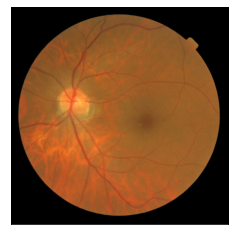

In [36]:
import torch
from torchvision import transforms
from matplotlib import pyplot as plt
toPIL = transforms.ToPILImage() #这个函数可以将张量转为PIL图片，由小数转为0-255之间的像素值
# img = torch.load('./ROB_discriptor/fake_1.pth')
img = torch.load('./fake_72.pth')
img = img*255
img = np.array(img,dtype='uint8')
img = np.squeeze(img)
# img = np.reshape(img,(299,299,3))
img=img.transpose(1,2,0)
b,g,r = cv2.split(img)
image= cv2.merge([r,g,b])
print(image.shape)
pic = toPIL(image)
plt.xticks([])
plt.yticks([])

plt.imshow(pic)

In [35]:
import numpy
setup_seed(2022)
for i in range(5):
    a=numpy.random.random(5)
    print(a)
print(" ")
for i in range(5):
    b=numpy.random.random(5)
    print(b)

[0.00935861 0.49905781 0.11338369 0.04997402 0.68540759]
[0.48698807 0.89765723 0.64745207 0.89696312 0.72113493]
[0.83135342 0.82756807 0.83357958 0.95704434 0.36804444]
[0.49483763 0.33950947 0.61942933 0.97752964 0.09643308]
[0.74420621 0.29249947 0.29867535 0.75247347 0.01866373]
 
[0.52373744 0.86443585 0.38884284 0.21219185 0.4751807 ]
[0.56467242 0.3494293  0.97590863 0.03782004 0.79426969]
[0.3578826  0.74796395 0.91450931 0.37266242 0.96488347]
[0.08138577 0.04245099 0.29679603 0.36370363 0.49025518]
[0.66851874 0.67341463 0.57210064 0.08059224 0.89833126]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import pandas as pd
from sklearn.kernel_ridge import KernelRidge

data = pd.read_csv('./resnet18_val loss.ipynb')
data1 = pd.read_csv('./baseline/entropy_patience.csv')
data2 = pd.read_csv('./baseline/entropy.csv')

xdata = data.iloc[:, data.columns.get_loc('Training dataset size')]
ydata = data.iloc[:, data.columns.get_loc('Accuracy')]

xdata1 = data1.iloc[:, data1.columns.get_loc('Training dataset size')]
ydata1 = data1.iloc[:, data1.columns.get_loc('Accuracy')]

# xdata2 = data2.iloc[:, data1.columns.get_loc('Training dataset size')]
# ydata2 = data2.iloc[:, data1.columns.get_loc('Accuracy')]

model=scipy.interpolate.make_interp_spline(xdata, ydata)
# model1=scipy.interpolate.make_interp_spline(xdata, ydata1)
# model2=scipy.interpolate.make_interp_spline(xdata, ydata2)
# model3=scipy.interpolate.make_interp_spline(xdata, ydata3)
# model4=scipy.interpolate.make_interp_spline(xdata, ydata4)

xdata=np.linspace(100,700,7)
ydata=model(xdata)

plt.plot(xdata,ydata,'g',label='deepfool_train',linewidth=1)
# plt.plot(xdata1,ydata1,'b',label='deepfool_val_last',linewidth=1)
# plt.plot(xdata2,ydata2,'y',label='deepfool_val_scratch',linewidth=1)
# plt.plot(xdata3,ydata3,'m',label='uncertainty',linewidth=1)
# plt.plot(xdata4,ydata4,'gold',label='deepfool',linewidth=1)
my_x_ticks = np.arange(100, 768, 100)
plt.xticks(my_x_ticks)
my_y_ticks = np.arange(0.64, 0.9, 0.04)
plt.yticks(my_y_ticks)

plt.title("Messidor",size=10)

plt.xlabel('Training dataset size')
plt.ylabel('Testing Accuracy')
plt.axhline(y=0.84, color = 'r', linewidth=2, linestyle="--", label='\nInception v3 at best accuracy' )
plt.legend()
plt.show()

ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 2
